In [298]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import CamembertTokenizer
import numpy as np
from collections import Counter

In [53]:
df_chunk = pd.read_csv('french_tweets.csv', chunksize=5)

In [60]:
n_tweets = 10000

lengths = []
for chunk in df_chunk:
    for tweet in chunk.text:
        lengths.append(len(tweet.split()))
    if len(lengths) >= n_tweets:
        break

10000 tweets


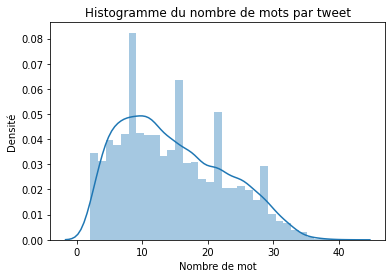

In [174]:
print(len(lengths), "tweets")
sns.distplot(lengths)
plt.title("Histogramme du nombre de mots par tweet")
plt.xlabel("Nombre de mot")
plt.ylabel("Densité")
plt.savefig(f'n_words_histogram_{len(lengths)}.png')
plt.show()

In [63]:
model_name = "camembert-base"
tokenizer = CamembertTokenizer.from_pretrained(model_name)

In [191]:
tweet = "Ceci est un exemple avec deux !!!?? fotes d'ortographe ⚽️⚾️ sans espace"

In [192]:
tokenizer.tokenize(tweet)

['▁Ceci',
 '▁est',
 '▁un',
 '▁exemple',
 '▁avec',
 '▁deux',
 '▁!!!',
 '??',
 '▁fo',
 'tes',
 '▁d',
 "'",
 'ort',
 'ographe',
 '▁',
 '⚽️⚾️',
 '▁sans',
 '▁espace']

In [197]:
tokenizer.tokenize('bhcuizehdeuz')

['▁b', 'h', 'cu', 'ize', 'h', 'de', 'uz']

In [190]:
tokenizer.decode(tokenizer.encode(tweet))

"<s> Ceci est un exemple avec deux!!!?? fotes d'ortographe <unk> sansespace</s>"

In [187]:
tokenizer.encode(tweet)

[5,
 2978,
 30,
 23,
 411,
 42,
 116,
 1309,
 6161,
 9557,
 1839,
 18,
 11,
 8607,
 18486,
 21,
 3,
 112,
 1179,
 6]

In [126]:
tokenizer.tokenize("ortographe")

['▁', 'ort', 'ographe']

In [125]:
tokenizer.encode('ortographe')

[5, 21, 8607, 18486, 6]

In [140]:
from spellchecker import SpellChecker

In [141]:
spell = SpellChecker(language='fr')

In [142]:
misspelled = ["resaissir", "matinnée", "plonbier", "tecnicien"]
misspelled = spell.unknown(misspelled)
for word in misspelled:
    print(word, spell.correction(word))

matinnée matinée
tecnicien technicien
resaissir ressaisir
plonbier plombier


In [158]:
spell.word_probability("un")

0.015231356190294348

In [159]:
spell.word_frequency.load_words(['testest'])

In [162]:
spell.correction("faut")

'faut'

In [215]:
voc = set(tokenizer.get_vocab().keys())

In [199]:
import spacy

In [206]:
nlp = spacy.load('fr')

In [232]:
list(nlp(tweet))

[Ceci,
 est,
 un,
 exemple,
 avec,
 deux,
 !,
 !,
 !,
 ?,
 ?,
 fotes,
 d',
 ortographe,
 ⚽,
 ️,
 ⚾,
 ️,
 sans,
 espace]

In [214]:
car = '▁'

In [220]:
car + 'rhum' in voc

True

In [229]:
spell.known(['diagnostic', 'oncologie', 'péridurale', 'cérébral'])

{'cérébral', 'diagnostic', 'oncologie', 'péridurale'}

In [239]:
words = list(map(str, nlp(tweet)))
words[:2]

['Ceci', 'est']

In [241]:
spell.known(words)

{'avec', 'ceci', 'deux', 'espace', 'est', 'exemple', 'sans', 'un'}

In [243]:
spell.known(list(map(spell.correction, words)))

{'avec',
 'ceci',
 'de',
 'deux',
 'espace',
 'est',
 'exemple',
 'notes',
 'orthographe',
 'sans',
 'un',
 'à'}

In [296]:
def in_camembert_voc(word):
    return car + word in voc

def analyze(tweet):
    words = list(map(str, nlp(tweet)))
    known = spell.known(words)
    known_corrected = spell.known(list(map(spell.correction, words)))
    unknown_camembert_words = [word for word in known_corrected if not in_camembert_voc(word)]
    return [len(words), len(set(words)), len(known), len(known_corrected), len(known_corrected) - len(unknown_camembert_words)], unknown_camembert_words

In [297]:
analyze(tweet)

([24, 19, 13, 17, 14], ['favorites', 'astres', 'spartan'])

In [304]:
n_tweets = 100

df_chunk = pd.read_csv('french_tweets.csv', chunksize=5)
stats = []
counter = Counter()

for chunk in df_chunk:
    for tweet in chunk.text:
        stat, l = analyze(tweet)
        stats.append(stat)
        counter.update(l)
    if len(stats) >= n_tweets:
        break

In [305]:
stats = np.array(stats)

In [306]:
n_words = stats[:,0]
n_distinct_words = stats[:,1]
n_known = stats[:,2]
n_known_corrected = stats[:,3]
n_known_camenbert = stats[:,4]

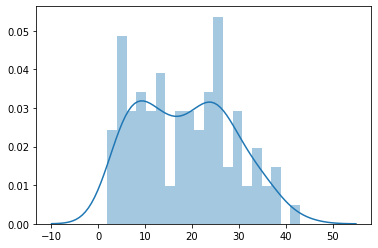

In [307]:
sns.distplot(n_words, bins=20)
plt.show()

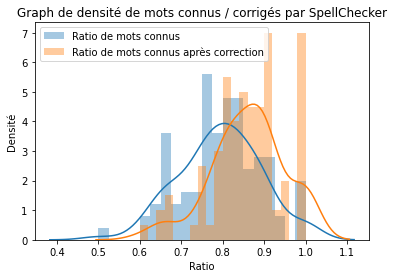

In [318]:
sns.distplot(n_known/n_distinct_words, bins=20)
sns.distplot(n_known_corrected/n_distinct_words, bins=20)
plt.legend(["Ratio de mots connus", "Ratio de mots connus après correction"])
plt.xlabel("Ratio")
plt.ylabel("Densité")
plt.title("Graph de densité de mots connus / corrigés par SpellChecker")
plt.savefig(f'spell_checker_{len(n_words)}.png')
plt.show()

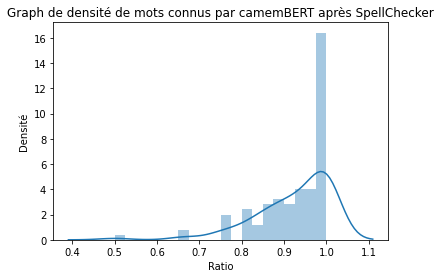

In [319]:
sns.distplot(n_known_camenbert/n_known_corrected, bins=20)
plt.xlabel("Ratio")
plt.ylabel("Densité")
plt.title("Graph de densité de mots connus par camemBERT après SpellChecker")
plt.savefig(f'camembert_known_words_{len(n_words)}.png')
plt.show()

In [310]:
(n_known_camenbert/n_known_corrected).mean()

0.9234076673287989

In [311]:
counter

Counter({'summer': 1,
         'carr': 1,
         'david': 1,
         'aww': 2,
         'aujourdhui': 5,
         'meurs': 1,
         'embarrassante': 1,
         'ua': 1,
         'ida': 1,
         'parles': 1,
         'zac': 1,
         'snyder': 1,
         'manques': 1,
         'aimerais': 1,
         'hollis': 1,
         'ahh': 1,
         'oubliées': 1,
         'buviez': 1,
         'blah': 1,
         'marley': 1,
         'refuserai': 1,
         'ooooh': 1,
         'leslie': 1,
         'fâcher': 1,
         'piraté': 1,
         'engrenage': 1,
         'anaheim': 1,
         'travaillerai': 1,
         'gmt': 1,
         'déprimant': 1,
         'larme': 1,
         'aise': 1,
         'endormir': 1,
         'tracy': 1,
         'yay': 1,
         'walking': 1,
         'blackberry': 1,
         'lily': 1,
         'samcro': 1,
         'tweeter': 1,
         'défilez': 1,
         'tweets': 1,
         'éclabousser': 1,
         'pos': 1,
         'dallas': 1,
  